### Run QG model to equilibrium and plot KE & PV

The model configuration will be identical to Zhang et al. (2020). We will use `run_with_snapshots` and `get_diagnostic` to save the PV anomaly and mean eddy kinetic energy.

In [1]:
import numpy as np
import xarray as xr
import pyqg
from pyqg import diagnostic_tools as tools
from pyqg import qg_model, particles
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})


In [2]:
# Set parameters & initialize model
year = 24*60*60*360.
twrite = 1000
tavestart = 2*year
m = pyqg.QGModel(tmax=10*year, twrite=twrite, tavestart=tavestart)

# set upper and lower PV anomaly in spatial coordinates
sig = 1.e-6
qi = sig*np.vstack([np.random.randn(m.nx,m.ny)[np.newaxis,],
                  np.random.randn(m.nx,m.ny)[np.newaxis,]])
m.set_q(qi) 


INFO:  Logger initialized


In [12]:
# Zhang set up:

day = 3600*24
year = 360*day
dt = day/72/2  # time step  

L = 1200e3   # domain size
Ld = 15e3  # Rossby deformation radius
nx = 256*2  # number of grid points in x direction

delta = 0.25
H1 = 4000*(delta/(1+delta)) #upper layer thickness [m]

U1 = 0.04  # layer 1 zonal velocity [m/s]
U2 = 0.0   # layer 2 zonal velocity [m/s]

rekday = 20
rek =  1/(rekday*day)   # linear bottom drag coeff. [s^-1] 
f0 = -1.2e-4    # Coriolis param. [s^-1]
beta = 1.3e-11  # planatery vorticity gradient [m^-1 s^-1]

Ti = Ld/abs(U1)
tmax = 10*year # tmax is like seconds in 10 years

m = pyqg.QGModel(nx=nx, L=L,dt=dt, tmax=tmax, twrite=50000, tavestart=10*year, 
               ntd=6, beta=beta, rd=Ld, delta=delta, H1=H1, U1=U1, U2=U2, rek=rek) 


sig = 1.e-6
qi = sig*np.vstack([np.random.randn(m.nx,m.ny)[np.newaxis,],
                  np.random.randn(m.nx,m.ny)[np.newaxis,]])
m.set_q(qi) 

INFO:  Logger initialized


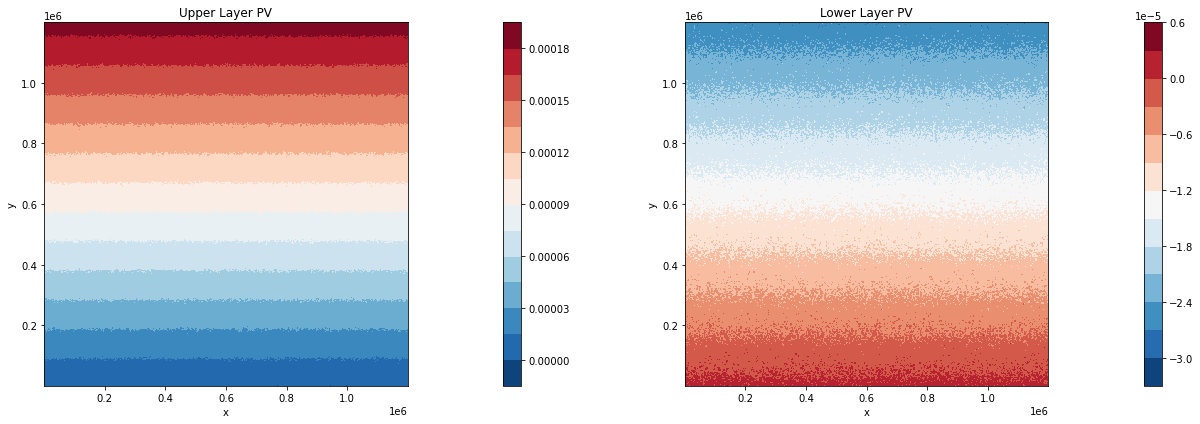

In [13]:
# Plot initialized PV 
qi_upper = m.q[0] + m.Qy[0]*m.y
qi_lower = m.q[1] + m.Qy[1]*m.y

plt.figure(figsize=(18,6))

plt.subplot(121)
plt.contourf(m.x, m.y, qi_upper, 12, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Upper Layer PV')
plt.colorbar(); plt.axis('square')

plt.subplot(122)
plt.contourf(m.x, m.y, qi_lower, 12, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Lower Layer PV')
plt.colorbar(); plt.axis('square')

plt.tight_layout();

In [4]:
# Model diagnostics 
m.describe_diagnostics()

NAME               | DESCRIPTION
--------------------------------------------------------------------------------
APEflux    | spectral flux of available potential energy           
APEgen     | total APE generation                                  
APEgenspec | spectrum of APE generation                            
EKE        | mean eddy kinetic energy                              
EKEdiss    | total energy dissipation by bottom drag               
Ensspec    | enstrophy spectrum                                    
KEflux     | spectral flux of kinetic energy                       
KEspec     |  kinetic energy spectrum                              
entspec    | barotropic enstrophy spectrum                         
q          | QGPV                                                  


In [ ]:
# Initialize lists for the PV anomaly and EKE
q = [qi]
eke = [[np.nan, np.nan]]
t = [0]

# n=0
for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=m.dt):
#     n+=1 # This counter controls when the EKE is appended to the list. 
    
    q.append(m.q) # PV anomaly
    t.append(m.t) # model time
#     if n > twrite*2: # EKE doesn't get computed until the first 'tavestart' interval 
    try:
        eke.append(m.get_diagnostic('EKE')) # mean eddy kinetic energy 
    except:
        eke.append([np.nan, np.nan])

# Convert to numpy arrays        
q_snapshots = np.asarray(q)
EKE_snapshots = np.asarray(eke)
t_snapshots = np.asarray(t)

#### Mean Eddy Kinetic Energy (EKE) as a function of time

model appears stable at time: 152668800.0


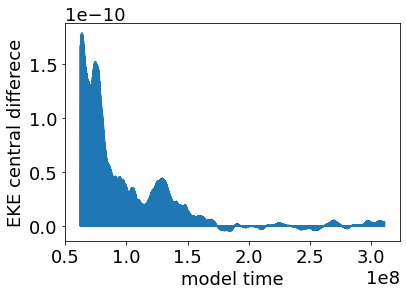

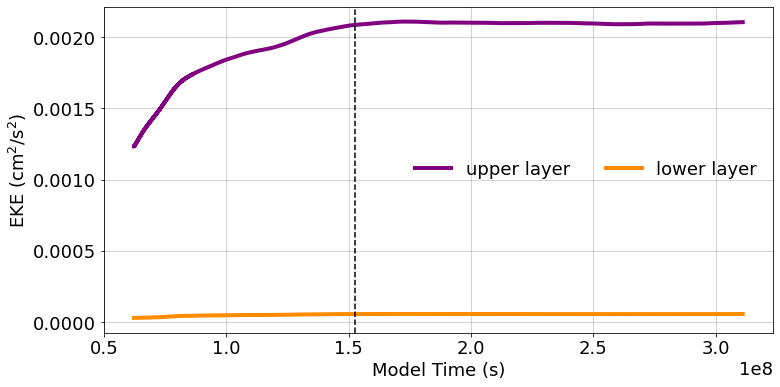

In [7]:
# Take derivative of upper layer EKE using a central difference
dEKE_dt = np.gradient(EKE_snapshots[:,0], t_snapshots)
I = np.where((dEKE_dt<0.1e-10)&(dEKE_dt>0)) [0]
EKE_stable = t_snapshots[I[0]]

# Plot EKE derivative
plt.rcParams.update({'font.size': 18})
plt.figure(); plt.plot(t_snapshots, dEKE_dt)
plt.ylabel('EKE central differece'); plt.xlabel('model time')

print('model appears stable at time:', EKE_stable)

# Plot time series of EKE
plt.figure(figsize=(12,6))
plt.plot(t_snapshots, EKE_snapshots[:,0], lw=4, color='purple', label='upper layer')
plt.plot(t_snapshots, EKE_snapshots[:,1], lw=4, color='darkorange', label='lower layer')
plt.axvline(x=EKE_stable, color='k', linestyle='--')
plt.grid(True, alpha=0.7); plt.legend(frameon=False, ncol=2)
plt.ylabel(r'EKE ($\rmcm^{2}$/$\rms^{2}$)'); plt.xlabel('Model Time (s)');

As the model gets spun up, the mean EKE increases until it reaches an equilibrated state. When the EKE plateaus the model is in a stable state. The dashed vertical line shows where the derivative of the upper layer EKE is minimum. This would be a good place to save the model state for the ensemble perturbation experiment.

### Evolution of the upper PV anomaly field

0
5000
10000
15000
20000
25000
30000
35000
40000


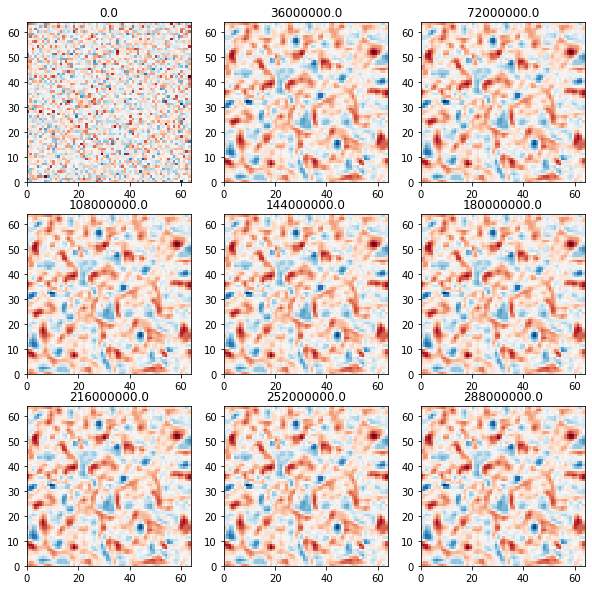

In [9]:
plt.rcParams.update({'font.size': 10})
lev=0 # level 1

plt.figure(figsize=(10,10))
for i in enumerate(range(0,len(q_snapshots),5000)):
    print(i[1])
    plt.subplot(3,3,i[0]+1)
    plt.pcolormesh(q_snapshots[i[1],lev,:,:], cmap='RdBu')
    plt.title(t_snapshots[i[1]])


The PV anomaly isn't evolving. Something is wrong. 

In [ ]:
plt.rcParams['image.cmap'] = 'RdBu'

# plt.ion()
plt.figure()
for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=1000*m.dt):
    
    plt.pcolormesh(m.q[0,:,:])


    plt.pause(0.01)

    plt.clf()

In [ ]:
m = pyqg.QGModel(tavestart=0,  dt=8000)

for snapshot in m.run_with_snapshots(
        tsnapstart=0, tsnapint=1000*m.dt):
    plt.clf()
    plt.imshow(m.q[0] + m.Qy1 * m.y)
    plt.clim([0,  m.Qy1 * m.W])
    plt.pause(0.01)
    plt.draw()

### Set up the model and parameters

In [ ]:
day = 3600*24 # seconds in day
year = 365*day # seconds in year
dt = day #/72/2  # time step  

L = 1200e3  # domain size
Ld = 15e3  # Rossby deformation radius
nx = 256*2  # number of grid points in x direction

delta = 0.25
H1 = 4000*(delta/(1+delta)) #upper layer thickness [m]

U1 = 0.04  # layer 1 zonal velocity [m/s]
U2 = 0.0   # layer 2 zonal velocity [m/s]

rekday = 20
rek =  1/(rekday*day)   # linear bottom drag coeff. [s^-1] 
f0 = -1.2e-4    # Coriolis param. [s^-1]
beta = 1.3e-11  # planatery vorticity gradient [m^-1 s^-1]

Ti = Ld/abs(U1)
tmax = 10*year # tmax is like seconds in 10 years

# twrite: Interval for cfl writeout (units: number of timesteps)
# tavestart: Start time for averaging (units: model time)

#### Initialize model:

In [ ]:
m = pyqg.QGModel(nx=nx, L=L, dt=dt, tmax=tmax, twrite=10000, tavestart=5*year, 
               ntd=6, beta=beta, rd=Ld, delta=delta, H1=H1, U1=U1, U2=U2, rek=rek) 

#### Set upper and lower layer PV anomalies (in spatial coordinates):

In [ ]:
sig = 1.e-6
qi = sig*np.vstack([np.random.randn(m.nx,m.ny)[np.newaxis,],
                  np.random.randn(m.nx,m.ny)[np.newaxis,]])
m.set_q(qi) 

In [ ]:
plt.pcolormesh(m.q[0,:,:])

#### Run model with snapshots

In [ ]:
q_snaps = xr.DataArray(data=m.q[:, np.newaxis,:,:],
                       dims=['z','time','x','y'],
                       coords={'z': [1,2], 'time': [m.t],'x': m.x[0,:] ,'y': m.y[:,0]})

for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=m.dt): 
    q_int = xr.DataArray(data=m.q[:, np.newaxis,:,:],
                       dims=['z','time','x','y'],
                       coords={'z': [1,2], 'time': [m.t],'x': m.x[0,:] ,'y': m.y[:,0]})
    q_snaps = xr.concat([q_snaps, q_int], "time")
    

In [ ]:
q_snaps[0,0,:,:].plot()

In [ ]:
m.describe_diagnostics()
eke = m.get_diagnostic('EKE')

In [ ]:
%%time
m.run()

Plot upper and lower PV anomalies.

In [ ]:
q_upper1=m.q[0]
q_upper2=m.q[1]

plt.figure(figsize=(18,4))
plt.rc('xtick', labelsize=20); plt.rc('ytick', labelsize=20)
plt.subplot(121)
plt.contourf(m.x, m.y, q_upper1, 24, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Upper Level PV')
plt.colorbar()
plt.subplot(122)
plt.contourf(m.x, m.y, q_upper2, 24, cmap='RdBu_r')
plt.xlabel('x'); plt.ylabel('y'); plt.title('Lower Level PV')
plt.colorbar()

### Set up Lagrangian particles and advect using gridded u and v

In [ ]:
dx = m.dx/2   # or 4
dy = m.dy/2

x0,y0 = np.meshgrid(np.arange(0,m.L,dx)+dx/2,
                    np.arange(0,m.W,dy)+dy/2)
pNy, pNx = x0.shape

x0 = x0.ravel()
y0 = y0.ravel()

Npart = x0.size
Ndays = 90 # times to integrate
Tpart = day*Ndays # length of particle trajectory
Tsave =  day  # daily data is saved
Nhold = Ndays # number of days to save
m.tmax = m.t + Tpart # let the model run some more by adding time to tmax


In [ ]:
%%time

Tstart = m.t/day
n = -1

particle_history = np.zeros((Nhold, 3, Npart))
q = np.zeros([Nhold, 2, m.ny ,m.nx])
ue = np.zeros([Nhold, m.ny, m.nx])
ve = np.zeros([Nhold, m.ny, m.nx])
pe = np.zeros([Nhold, m.ny, m.nx])

lpa = particles.GriddedLagrangianParticleArray2D(x0, y0, m.nx, m.ny,
        periodic_in_x=True, periodic_in_y=True,
        xmin=0, xmax=m.L, ymin=0, ymax=m.W)

# set up extended grid for lagrangian particles
x = np.hstack([m.x[0,0]-m.dx, m.x[0,:], m.x[0,-1]+m.dx])
y = np.hstack([m.y[0,0]-m.dy, m.y[:,0], m.y[-1,0]+m.dy])

uprev = m.ufull[0].copy()   
vprev = m.vfull[0].copy()
for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=m.dt): 

    # set up velocities for Lagrangian advection
    u = m.ufull[0]
    v = m.vfull[0]
    
    lpa.step_forward_with_gridded_uv(uprev, vprev, u, v, m.dt)

    uprev = u.copy()
    vprev = v.copy()

    if n==-1:
        qi = m.q[0].copy()
        ui = u.copy()
        vi = v.copy()
        
        n+=1
        
    if (m.t % Tsave)==0:
        if (m.t*(Tsave*10))==0:
            print(m.t, n)

        # calculate relative vorticity using PV anomaly
        p = m.ifft(m.ph)
        vort = m.q[0] - m.F1*(p[1]-p[0])
        
        # vorticty on particles
        pvort = lpa.interpolate_gridded_scalar(lpa.x, lpa.y, vort)

        particle_history = np.roll(particle_history, 1, axis=0)
        particle_history[0,0] = lpa.x
        particle_history[0,1] = lpa.y
        particle_history[0,2] = pvort
        # time goes backwards in particle history
        
        q = np.roll(q, 1, axis=0)
        q[0] = m.q
        ue = np.roll(ue, 1, axis=0)
        ue[0] = m.u[0]
        ve = np.roll(ve, 1, axis=0)
        ve[0] = m.v[0]
        pe = np.roll(pe, 1, axis=0)
        pe[0] = p[0]

        n+=1

### RCLV identification

In [ ]:
def plot_xy(Xseg,Yseg,L): 
    '''plot trajectories over periodic boundaries'''
    plt.plot(Xseg,Yseg,'k',linewidth=3) #,'k',linewidth=3
    plt.plot(Xseg-L,Yseg,'k',linewidth=3)
    plt.plot(Xseg+L,Yseg,'k',linewidth=3)
    plt.plot(Xseg,Yseg-L,'k',linewidth=3)
    plt.plot(Xseg,Yseg+L,'k',linewidth=3)
    plt.xlim([0,L])
    plt.ylim([0,L])

In [ ]:
%%time
# Eddy detection

lav_abs = np.abs(particle_history[:,2].copy())  # absolute value of vorticity on particles
lx,ly = particle_history[:,0].copy(),particle_history[:,1].copy() # particle trjectories

# lq = np.zeros([Nhold,Npart])
# for i in range(Nhold):
#     lq[i] = lpa.interpolate_gridded_scalar(lx[i], ly[i], q[i,0]) # get the PV on particles (if needed)
    
lx.shape = (Nhold, pNy, pNx)
ly.shape = (Nhold, pNy, pNx)
lav_abs.shape = (Nhold, pNy, pNx)
# lq.shape = (Nhold, pNy, pNx)

lx1 = np.unwrap(lx[::-1]*2*pi/m.W, axis=0)*m.W/(2*pi)  # unwrap trajectories to correct the jump of displacement at the periodic boundaries
ly1 = np.unwrap(ly[::-1]*2*pi/m.L, axis=0)*m.L/(2*pi)
lx1 = lx1[::-1]  # switch back to backward timing
ly1 = ly1[::-1]

ndays1 = 60  # lifetime of RCLV
lavd1 = lav_abs[-ndays1:].mean(axis=0)  #LAVD field 
del(lav_abs)

cov1 = 10.0  # convexity deficincy threshold, here uses 10.0 to disable it
CI = -0.75   # threshold for coherency index
min_area = 200  # minimum area (number of pixels) of RCLV

kwargs = dict(min_distance=20,  # minimum distance between LAVD maxima (pixel units)
              max_width=100,    # maximum width of the search window (pixel units)
              CI_th=CI, CI_tol=0.01, convex_def=cov1, convex_def_tol=0.001, 
              init_contour_step_frac=0.64,  # the value with which to increment the initial contour level
              min_limit_diff=1e-10, min_area=min_area, periodic=(True, True))

contours1 = list(rclv.find_convex_contours(lavd1, 
                                           lx1[-1:-ndays1-1:-1], ly1[-1:-ndays1-1:-1], 
                                           dx=dx, dy=dy, # particle spacing, must have the same unit as lx1 and ly1
                                           **kwargs))

mask = rclv.label_points_in_contours(lavd1.shape, [c[1] for c in contours1])  #label particles in RCLVs



In [ ]:
snap = 0
fig = plt.figure(120+snap, figsize=(14,14))
plt.title('%s-day RCLVs: Bisection searching with CI>%s and cd<%s'%(ndays1,CI,cov1))  
plt.imshow(q[-1,0]*1e5, origin='lower', extent=((0,m.L/1000,0,m.W/1000)), cmap='RdBu_r') # plot the PV field at inital time
plt.xlabel('x(km)')
plt.ylabel('y(km)')
clt = plt.colorbar()
clt.set_label('PV($10^{-5}s^{-1}$)')

for n,contour in enumerate(contours1):
    if (mask==n+1).sum()==0:  # sometimes an eddy may not be masked
        continue

    xc = np.mean(lx1[:,mask==n+1], axis=-1)  # the center of particle cloud in the n-th RCLV
    yc = np.mean(ly1[:,mask==n+1], axis=-1)

    plt.figure(120+snap)
    plot_xy(xc[-1:-ndays1:-1]/1e3,yc[-1:-ndays1:-1]/1e3,m.L/1e3)  # trajectory of the center of particle cloud
    plt.plot(lx[-ndays1,mask==n+1]/1e3,ly[-ndays1,mask==n+1]/1e3,'.')  # particle postions at the last time
    plt.plot(contour[1][:,1]*dx/1e3,contour[1][:,0]*dx/1e3,'r',linewidth=3)  # boundary of RCLV at the initial time
    plt.plot(contour[0][1]*dx/1e3,contour[0][0]*dx/1e3,'yo')  # center of particle cloud at the initial time
